In [2]:
#This code was created in google colab and hence the commands that handle external files shall be different.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
#importing necessary libraries for dataset extraction from .json file

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO

In [0]:
#Change current working directory to the directory containing the .json file

os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset/") 

#Since the .json file contains multiple Json objects, they shall be stored as a list of dictionaries in python

data = []
for line in open('Face_Recognition.json', 'r'):
    data.append(json.loads(line))

#data is now a list of dictionaries where each dictionary represents one entry into the dataset
#Now we check  if the label field in the entire dataset contains any unwanted fields. For example here we have 'Not_Face' as an undesirable label

label = []
a = len(data)
for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    k = data[i]['annotation'][j]['label']
    if len(k)!=0 and len(k)!=1:
      for p in range(0,len(k)):
        label.append(k[p])

#label now contains a sum total of all the labels in the entire dataset. Converting it to set allows us to see all unique entries within it, sans repetition.
print(len(label))
print(set(label))
print(k)

print(k[1].split('_',1)[0].strip())

803
{'Age_20_30', 'E_White', 'E_Arab', 'Age_40_50', 'E_Black', 'Emotion_Happy', 'E_Hispanic', 'Not_Face', 'Emotion_Neutral', 'Emotion_Sad', 'G_Male', 'Emotion_Angry', 'E_Indian', 'Age_below20', 'Age_30_40', 'E_Asian', 'G_ Female', 'Age_above_50'}
['Emotion_Happy', 'Age_above_50', 'E_White', 'G_Male']
Age


In [0]:
#Data preprocessing
#Here we work to make the data easier to manipulate.
#First we add none values wherever needed. This is done becase separate models will classify Emotion, Age and Ethnicity.
#If time permits we shall also classify gender although it is not required by the problem statement.
#After adding nones, we sort the data so that we can easily split it into emotion, age, ethnicity and gender.
#We also remove the unwanted fields


for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    k = data[i]['annotation'][j]['label']
    label = []
    label = [m.split('_',1)[0].strip() for m in k]
    if 'E' not in label:
      k.append('E_None')
    
    if 'G' not in label:
      k.append('G_None')
    
    if 'Age' not in label:
      k.append('Age_None')
    
    if 'Emotion' not in label:
      k.append('Emotion_None')
    
    if 'Not' in label:
      k.remove('Not_Face')
    
    k.sort(key = lambda x: x.split('_')[0])#to sort the values only by label names
    
    print(i,end='  ')
    print(j)
    print(label)
    print(k)
    
    data[i]['annotation'][j]['label'] = [v.split('_',1)[1].strip() for v in k]
    print(data[i]['annotation'][j]['label'])
    
#manually adding two labels with ambigous data
data[47]['annotation'][0]['label'] = ['None', 'None', 'Neutral', 'None']
data[68]['annotation'][2]['label'] = ['20_30', 'None', 'Neutral', 'Male']
    

0  0
['Emotion', 'Age', 'E', 'G']
['Age_below20', 'E_White', 'Emotion_Happy', 'G_Male']
['below20', 'White', 'Happy', 'Male']
0  1
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_White', 'Emotion_Happy', 'G_ Female']
['20_30', 'White', 'Happy', 'Female']
1  0
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_Hispanic', 'Emotion_Happy', 'G_ Female']
['20_30', 'Hispanic', 'Happy', 'Female']
1  1
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_White', 'Emotion_Happy', 'G_ Female']
['20_30', 'White', 'Happy', 'Female']
1  2
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_White', 'Emotion_Happy', 'G_ Female']
['20_30', 'White', 'Happy', 'Female']
2  0
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_Asian', 'Emotion_Neutral', 'G_ Female']
['20_30', 'Asian', 'Neutral', 'Female']
2  1
['Emotion', 'Age', 'E', 'G']
['Age_below20', 'E_White', 'Emotion_Neutral', 'G_ Female']
['below20', 'White', 'Neutral', 'Female']
2  2
['Emotion', 'Age', 'E', 'G']
['Age_20_30', 'E_White', 'Emotion_Neutral', 'G_ Female']
['2

In [0]:
#Since one image may have many faces within it, the same image and image dimensions would be loaded multiple times unnecassarily. 
#In order to solve this issue memoization is used

cache = {}
def img_ret(i):
  if cache.get(i) is not None:
    return cache[i]
  cache[i] = [Image.open(BytesIO(requests.get(data[i]['content']).content)),data[i]['annotation'][0]['imageWidth'],data[i]['annotation'][0]['imageHeight']]
  return cache[i]

#Define the image cropping function

def img_crop_resize(i,j):
  Image_call = img_ret(i)
  Im = Image_call[0]
  w = Image_call[1]
  h = Image_call[2]
  x1 = data[i]['annotation'][j]['points'][0]['x']*w
  y1 = data[i]['annotation'][j]['points'][0]['y']*h
  x2 = data[i]['annotation'][j]['points'][1]['x']*w
  y2 = data[i]['annotation'][j]['points'][1]['y']*h
  width = 224
  height = 224
  return np.array(Im.crop((x1,y1,x2,y2)).resize((width, height), Image.ANTIALIAS))#antialias is one of the best filters for resizing the image

  
  

In [0]:
Age = []
Ethnicity = []
Emotion = []
Gender = []
Images =  []
for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    Age.append(data[i]['annotation'][j]['label'][0])
    Ethnicity.append(data[i]['annotation'][j]['label'][1])
    Emotion.append(data[i]['annotation'][j]['label'][2])
    Gender.append(data[i]['annotation'][j]['label'][3])
    Images.append(img_crop_resize(i,j))



In [0]:

print(Age.count('20_30'))
print(Age.count('40_50'))
print(Age.count('below20'))
print(Age.count('30_40'))
print(Age.count('above_50'))
print("labels :", set(Age))
print(len(Age[50:]))
c = 0
j = -1
for i in Age:
  j = j + 1
  if i != 'None':
    c = c+1
  if c == 151:
    print(j)



90
17
18
61
14
labels : {'below20', '20_30', '40_50', 'above_50', 'None', '30_40'}
301
254


In [0]:
import cv2
os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset/Age_train")
train = Age[:255]
j = -1
for i in train:
  j = j + 1
  if i == '40_50':
    name = '40_50/Image'+str(j)+'.jpg'
    cv2.imwrite(os.path.join(path, name),Images[j])
  elif i == '30_40':
    name = '30_40/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == 'above_50':
    name = 'above_50/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == 'below20':
    name = 'below20/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == '20_30':
    name = '20_30/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  


['below20', '20_30', '20_30', '20_30', '20_30', '20_30', 'below20', '20_30', '20_30', 'None', 'None', 'None', 'None', 'None', 'above_50', '30_40', 'above_50', '30_40', '30_40', '30_40', '20_30', '30_40', '20_30', 'None', 'None', '20_30', '20_30', '30_40', 'None', 'above_50', 'None', 'above_50', 'None', '20_30', 'None', 'None', 'None', 'None', '30_40', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '40_50', '20_30', 'None', 'None', 'None', 'None', 'None', 'None', '30_40', '30_40', 'above_50', 'below20', 'None', 'None', 'None', '20_30', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '20_30', '20_30', '20_30', '20_30', '20_30', '30_40', 'below20', '30_40', 'None', 'None', '40_50', 'None', 'None', 'None', '30_40', '20_30', '30_40', 'below20', 'below20', '30_40', '20_30', '30_40', '20_30', 'below20', '40_50', 'None', '20_30', '30_40', 'None', 'None', 'None', 'above_50', 'None', '20_30', '30_40', 'None', '40_50', 'below20', '30_40', '30_40', '20_30', '20_30'

In [0]:
os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset/Age_test")
for i in Age[255:]:
  j = j + 1
  if i == '40_50':
    name = '40_50/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == '30_40':
    name = '30_40/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == 'above_50':
    name = 'above_50/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == 'below20':
    name = 'below20/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])
  elif i == '20_30':
    name = '20_30/Image'+str(j)+'.jpg'
    cv2.imwrite(name,Images[j])


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset")
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="Age_train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="Age_test", target_size=(224,224))

Found 151 images belonging to 5 classes.
Found 49 images belonging to 5 classes.


In [0]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=4096))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(Dense(units=4096))
model.add(keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(Dense(units=5, activation="softmax"))

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 224, 224, 64)      3211264   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 112, 112, 128)     1605632   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)    

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg11_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=10,generator=traindata, validation_data= testdata, validation_steps=10,epochs=10,callbacks=[checkpoint,early])

Epoch 1/10
10/10 [==============================] - 411s 41s/step - loss: 8.2289 - acc: 0.4895 - val_loss: 10.8550 - val_acc: 0.3265

Epoch 00001: val_acc improved from -inf to 0.32653, saving model to vgg11_1.h5
Epoch 2/10
10/10 [==============================] - 418s 42s/step - loss: 8.3185 - acc: 0.4839 - val_loss: 10.8550 - val_acc: 0.3265

Epoch 00002: val_acc improved from 0.32653 to 0.32653, saving model to vgg11_1.h5
Epoch 3/10
10/10 [==============================] - 416s 42s/step - loss: 8.1931 - acc: 0.4917 - val_loss: 10.8550 - val_acc: 0.3265

Epoch 00003: val_acc improved from 0.32653 to 0.32653, saving model to vgg11_1.h5
Epoch 4/10
10/10 [==============================] - 412s 41s/step - loss: 8.1931 - acc: 0.4917 - val_loss: 10.8550 - val_acc: 0.3265

Epoch 00004: val_acc did not improve from 0.32653
Epoch 5/10
10/10 [==============================] - 409s 41s/step - loss: 8.2826 - acc: 0.4861 - val_loss: 10.8550 - val_acc: 0.3265

Epoch 00005: val_acc did not improve 

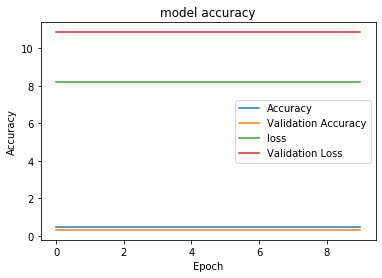

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [1]:
!pip install mtcnn

In [2]:
from keras.preprocessing import image
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2

#os.kill(os.getpid(), 9)

detector = MTCNN()

predict = ['Age: below 20','Age: above 50','Age: between 40 to 50','Age: between 30 to 40','Age: between 20 to 30']

def face_crop_pred(image):
  im = image
  result = detector.detect_faces(np.array(im))
  bounding_box = result[0]['box']
  print(type(bounding_box[0]))
  keypoints = result[0]['keypoints']
  im = im.crop((bounding_box[0], bounding_box[1], bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3])).resize((224,224), Image.ANTIALIAS)
  im = np.expand_dims(im, axis=0)
  saved_model = load_model("vgg11_1.h5")
  output = saved_model.predict(im)
  print(output)
  text = predict[int(list(output[0]).index(1.0))]
  image = np.array(image)
  cv2.rectangle(image,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),(255,0,0), 5)
  cv2.putText(image, text, (bounding_box[0]-150,bounding_box[1]+bounding_box[3]+150), cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 0, 0), 15, lineType=cv2.LINE_AA)
  return image



Using TensorFlow backend.


(3264, 1504, 3)
<class 'int'>


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[[1. 0. 0. 0. 0.]]


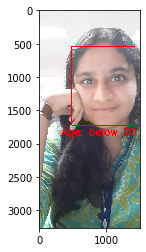

In [3]:
import os
import numpy as np
from PIL import Image
os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset")
img = image.load_img("/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset/diva2.jpg")
plt.imshow(img)
print(np.array(img).shape)
plt.imshow(face_crop_pred(img))


